Raster Classification Steps
You can break your raster processing workflow into several steps as follows:

Data import / cleanup: load and “clean” the data. This includes cropping, removing with nodata values
Data Exploration: understand the range and distribution of values in your data. This may involve plotting histograms and scatter plots to determine what classes are appropriate for our data
Reclassify the Data: Once you understand the distribution of your data, you are ready to reclassify. There are statistical and non-statistical approaches to reclassification. Here you will learn how to manually reclassify a raster using bins that you define in your data exploration step.
Please note - working with data is not a linear process. Above you see a potential workflow. You will develop your own workflow and approach.

To get started, first load the required libraries and then open up your raster. In this case, you are using the lidar canopy height model (CHM) that you calculated in the previous lesson.

In [1]:
import os

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
import seaborn as sns
sns.set(font_scale=1.5, style="whitegrid")

In [2]:
# Define relative paths to DTM and DSM files
dtm_path = os.path.join("data", "data", "colorado-flood",
                        "spatial",
                        "boulder-leehill-rd",
                        "pre-flood",
                        "lidar",
                        "pre_DTM.tif")

dsm_path = os.path.join("data", "data", "colorado-flood",
                        "spatial",
                        "boulder-leehill-rd",
                        "pre-flood",
                        "lidar",
                        "pre_DSM.tif")

# Open DTM and DSM files. Digital Terrain Model, and Digital Surface Model (I think, AKA a Digital Elevation Model)
pre_lidar_dtm = rxr.open_rasterio(dtm_path, masked=True).squeeze()
pre_lidar_dsm = rxr.open_rasterio(dsm_path, masked=True).squeeze()

# Create canopy height model (CHM)
pre_lidar_chm = pre_lidar_dsm - pre_lidar_dtm
pre_lidar_chm

<xarray.DataArray (y: 2000, x: 4000)>
array([[       nan,        nan,        nan, ..., 0.        , 0.17004395,
        0.960083  ],
       [       nan,        nan,        nan, ..., 0.        , 0.09008789,
        1.6400146 ],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.07995605],
       ...,
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int64 0

What Classification Values to Use?
There are many different approaches to classification. Some use highly sophisticated spatial algorithms that identify patterns in the data that can in turn be used to classify particular pixels into particular “classes”.

In this case, you are simply going to create the classes manually using the range of quantitative values found in our data.

Assuming that our data represent trees (though you know there are likely some buildings in the data), classify your raster into 3 classes:

Short trees
Medium trees
Tall trees
To perform this classification, you need to understand which values represent short trees vs medium trees vs tall trees in your raster. This is where histograms can be extremely useful.

Start by looking at the min and max values in your CHM.

In [3]:
# View min and max values in the data
print('CHM min value:', np.nanmin(pre_lidar_chm))
print('CHM max value:', np.nanmax(pre_lidar_chm))

CHM min value: 0.0
CHM max value: 26.930054


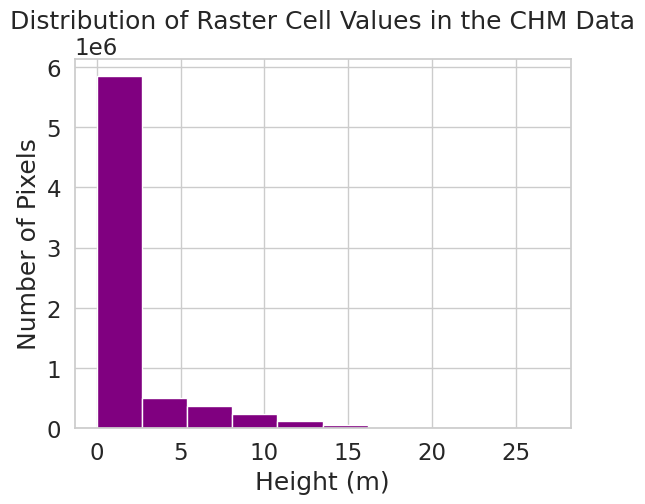

In [4]:
f, ax = plt.subplots()
pre_lidar_chm.plot.hist(color="purple")
ax.set(title="Distribution of Raster Cell Values in the CHM Data",
       xlabel="Height (m)",
       ylabel="Number of Pixels")
plt.show()

Explore Raster Histograms
Further explore your histogram, by constraining the x axis limits using the xlim and ylim parameters.

These lim parameters visually zooms in on the data in the plot. It does not modify the data.

You might also chose to adjust the number of bins in your plot. Below you plot a bin for each increment on the x axis calculated using:

hist_range(*xlim)

You could also set bins = 100 or some other value if you wish.

You can look at the values that Python used to draw your histogram, too.

To do this, you can collect the outputs that are returned when you call np.histogram. This consists of two things:

counts, which represents the number of items in each bin
bins, which represents the edges of the bins (there will be one extra item in bins compared to counts)
Each bin represents a bar on your histogram plot. Each bar represents the frequency or number of pixels that have a value within that bin.

Notice that you have adjusted the xlim and ylim to zoom into the region of the histogram that you are interested in exploring; however, the values did not actually change.

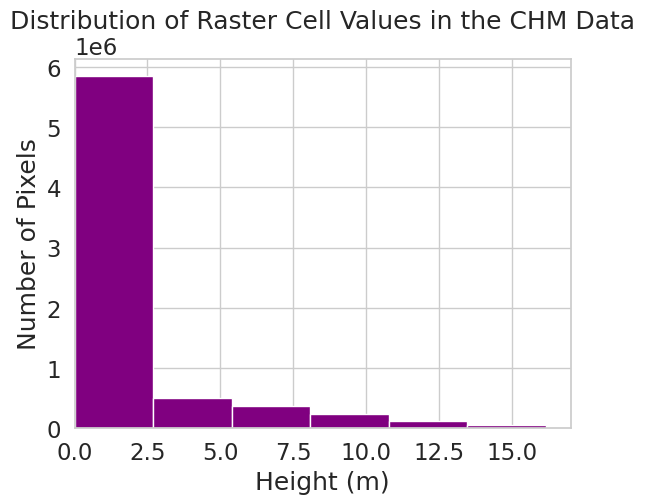

In [5]:
f, ax = plt.subplots()
pre_lidar_chm.plot.hist(color="purple")
ax.set(title="Distribution of Raster Cell Values in the CHM Data",
       xlabel="Height (m)",
       ylabel="Number of Pixels")
ax.set_xlim(0,17)
# ax.set_ylim(0,5)
plt.show()

Histogram with Custom Breaks
Customize your histogram with breaks that you think might make sense as breaks to use for your raster map.

In the example below, breaks are added in 5 meter increments using the bins = argument.

bins=[0, 5, 10, 15, 20, 30]

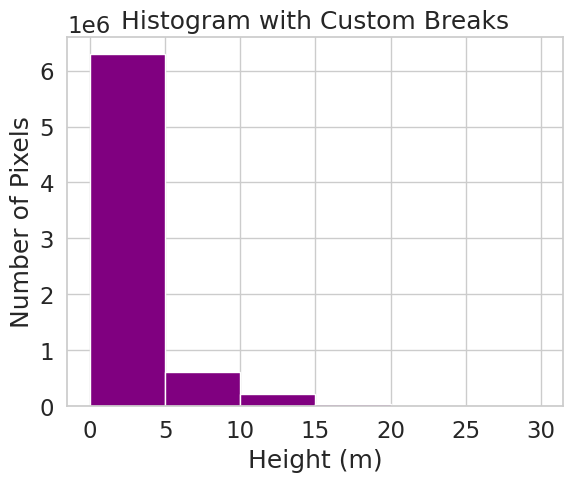

In [6]:
# Histogram with custom breaks
f, ax = plt.subplots()
pre_lidar_chm.plot.hist(color="purple",
                        bins=[0, 5, 10, 15, 20, 30])
ax.set(title="Histogram with Custom Breaks",
       xlabel="Height (m)",
       ylabel="Number of Pixels")

plt.show()

You may want to play with the distribution of breaks. Below it appears as if there are many values close to 0.

In the case of this lidar instrument, you know that values between 0 and 2 meters are not reliable (you know this if you read the documentation about the NEON sensor and how these data were processed).

Below you create a bin between 0-2.

You also know you want to create bins for short, medium and tall trees, so experiment with those bins as well.

Below following breaks are used:

0 - 2 = no trees
2 - 7 = short trees
7 - 12 = medium trees
> 12 = tall trees

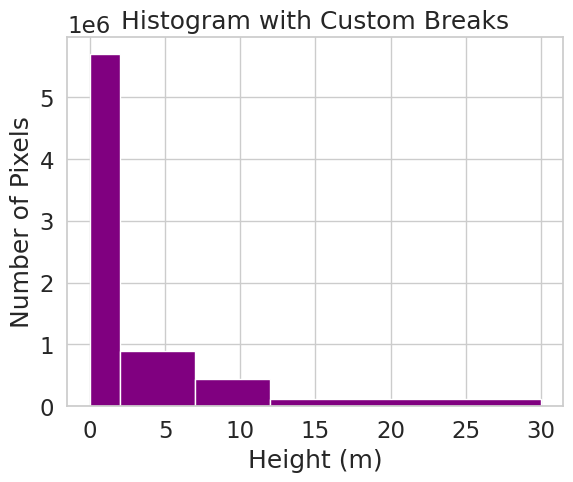

In [7]:
# Histogram with custom breaks
f, ax = plt.subplots()

pre_lidar_chm.plot.hist(
    color='purple',
    bins=[0, 2, 7, 12, 30])
ax.set(title="Histogram with Custom Breaks",
       xlabel="Height (m)",
       ylabel="Number of Pixels")

plt.show()

Map Raster Values to New Values
To reclassify your raster, first you need to create a reclassification matrix.

This matrix MAPS a range of values to a new defined value. You will use this matrix to create a classified canopy height model where you designate short, medium and tall trees.

The newly defined values will be as follows:

No trees: (0m - 2m tall) = NA
Short trees: (2m - 7m tall) = 1
Medium trees: (7m - 12m tall) = 2
Tall trees: (> 12m tall) = 3
Notice in the list above that you set cells with a value between 0 and 2 meters to NA or nodata value. This means you are assuming that there are no trees in those locations!

Notice in the matrix below that you use Inf to represent the largest or max value found in the raster. So our assignment is as follows:

0 - 2 meters -> 1
2 - 7 meters -> 2 (short trees)
7 - 12 meters -> 3 (medium trees)
> 12 or 12 - Inf -> 4 (tall trees)
Below you create the matrix.

np.digitize
Numpy has a function called digitize that is useful for classifying the values in an array. It is similar to how histogram works, because it categorizes datapoints into bins. However, unlike histogram, it doesn’t aggregate/count the number of values within each bin.

Instead, digitize will replace each datapoint with an integer corresponding to which bin it belongs to. You can use this to determine which datapoints fall within certain ranges.

When you use np.digitize, the bins that you create work as follows:

The starting value by default is included in each bin. The ending value of the bin is not and will be the beginning of the next bin. You can add the argument right = True if you want the second value in the bin to be included but not the first.
Any values BELOW the bins as defined will be assigned a 0. Any values ABOVE the highest value in your bins will be assigned the next value available. Thus, if you have:
class_bins = [0, 2, 7, 12, 30]

Any values that are equal to 30 or larger will be assigned a value of 5. Any values that are < 0 will be assigned a value of 0.

Oftentimes, you can use np.inf in your array to include all values greater than the last value, and you can use -np.inf in your array to include all values less than the first value.

However, if you are using the class bins for a BoundaryNorm object for a plot,np.inf will throw an error in matplotlib. The BoundaryNorm object cannot handle an infinity value, so you must supply it with an actual integer.

A good stand in for np.inf is the maximum value numpy can store as an integer, which can be accessed by using np.iinfo(np.int32).max. This will have the same effect as np.inf without breaking the BoundaryNorm object.

Likewise, you can use the minimum value of the array (arr.min()) instead of -np.inf.

In [8]:
# Check nodata value for your array
pre_lidar_chm.rio.nodata

Below you define 4 bins. However, you end up with a fifth class == 0 which represents values smaller than 0 which is the minimum value in your chm.

These values < 0 come from the numpy mask fill value which you can see identified above this text

In [9]:
data_min_value = np.nanmin(pre_lidar_chm)
data_max_value = np.nanmax(pre_lidar_chm)
print(data_min_value, data_max_value)

0.0 26.930054


In [10]:
class_bins = [-np.inf, 2, 7, 12, np.inf]
class_bins

[-inf, 2, 7, 12, inf]

In [11]:
pre_lidar_chm_class = xr.apply_ufunc(np.digitize,
                                     pre_lidar_chm,
                                     class_bins)

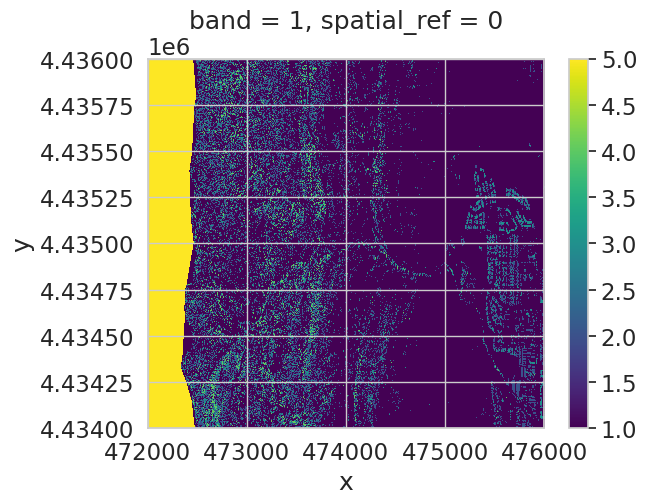

In [12]:
# Values of 5 represent missing data
im = pre_lidar_chm_class.plot.imshow()
ax.set_axis_off()

In [13]:
# Mask out values not equalt to 5
pre_lidar_chm_class_ma = pre_lidar_chm_class.where(pre_lidar_chm_class != 5)
pre_lidar_chm_class_ma

<xarray.DataArray (y: 2000, x: 4000)>
array([[nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       ...,
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.]])
Coordinates:
    band         int64 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int64 0

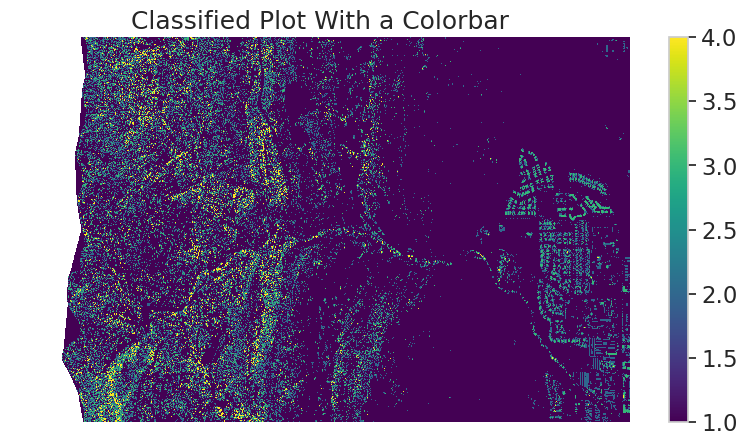

In [14]:
# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10,5))
pre_lidar_chm_class_ma.plot.imshow()
ax.set(title="Classified Plot With a Colorbar")

ax.set_axis_off()
plt.show()

Below is the same with better colors

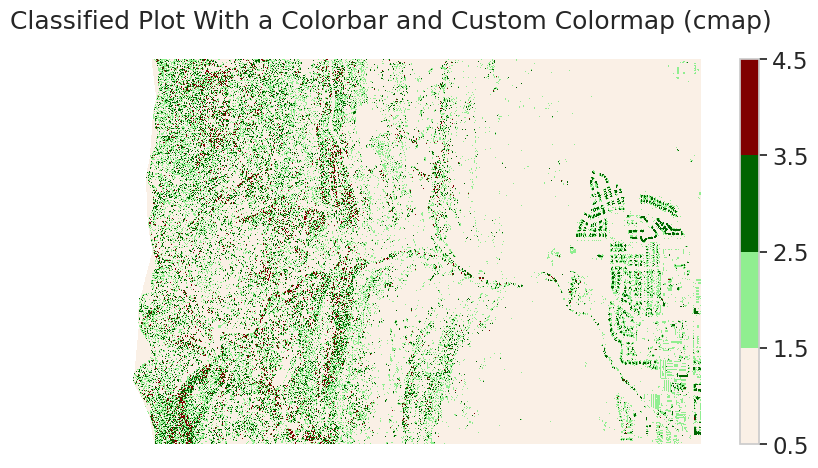

In [15]:
# Plot data using nicer colors
colors = ['linen', 'lightgreen', 'darkgreen', 'maroon']
class_bins = [.5, 1.5, 2.5, 3.5, 4.5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, 
                    len(colors))

# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10, 5))
pre_lidar_chm_class_ma.plot.imshow(cmap=cmap,
                                   norm=norm)
ax.set(title="Classified Plot With a Colorbar and Custom Colormap (cmap)")
ax.set_axis_off()
plt.show()


Add a Custom Legend to Your Plot with EarthPy
The plot looks OK but the legend does not represent the data well. The legend is continuous - with a range between 1.0 and 4.0 However, you want to plot the data using discrete bins.

Given you have discrete values, you can create a custom legend with the four categories that you created in your classification matrix.

There are a few tricky pieces to creating a custom legend.

Notice below that you first create a list of legend items (or labels):
height_class_labels = ["Short trees", "Less short trees", "Medium trees", "Tall trees"]

This represents the text that will appear in your legend.

Next you create the colormap from a list of colors.
This code: colors = ['linen', 'lightgreen', 'darkgreen', 'maroon'] creates the color list.

And this code: cmap = ListedColormap(colors) creates the colormap to be used in the plot code.

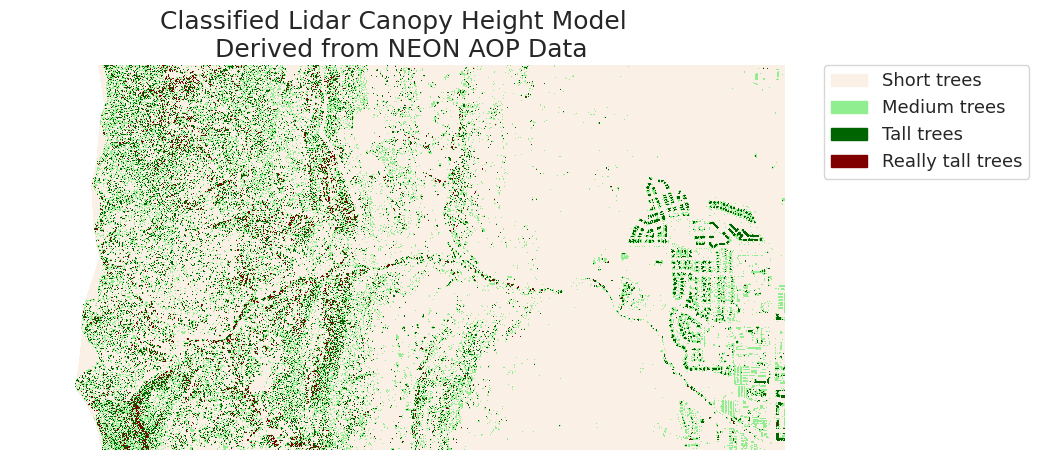

In [16]:
# Create a list of labels to use for your legend
height_class_labels = ["Short trees",
                       "Medium trees",
                       "Tall trees",
                       "Really tall trees"]

# Create a colormap from a list of colors
colors = ['linen',
          'lightgreen',
          'darkgreen',
          'maroon']

cmap = ListedColormap(colors)

class_bins = [.5, 1.5, 2.5, 3.5, 4.5]
norm = BoundaryNorm(class_bins,
                    len(colors))

# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10, 5))
im = pre_lidar_chm_class_ma.plot.imshow(cmap=cmap,
                                        norm=norm,
                                        # Turn off colorbar
                                        add_colorbar=False)
# Add legend using earthpy
ep.draw_legend(im,
               titles=height_class_labels)
ax.set(title="Classified Lidar Canopy Height Model \n Derived from NEON AOP Data")
ax.set_axis_off()
plt.show()

Optional Challenge: Plot Change Over Time
Create a classified raster map that shows positive and negative change in the canopy height model before and after the flood. To do this you will need to calculate the difference between two canopy height models.
Create a classified raster map that shows positive and negative change in terrain extracted from the pre and post flood Digital Terrain Models before and after the flood.
For each plot, be sure to:

Add a legend that clearly shows what each color in your classified raster represents.
Use better colors than I used in my example above!
Add a title to your plot.
You will include these plots in your final report due next week.

Check out this cheatsheet for more on colors in matplotlib.

to answer ^ this, I need to play around with the histogram bins and see how to best group the values, plot it choose good colors and legend

In [17]:
dtm_path_post = os.path.join("data", "data", "colorado-flood",
                        "spatial",
                        "boulder-leehill-rd",
                        "post-flood",
                        "lidar",
                        "post_DTM.tif")
dsm_path_post = os.path.join("data", "data", "colorado-flood",
                        "spatial",
                        "boulder-leehill-rd",
                        "post-flood",
                        "lidar",
                        "post_DSM.tif")

In [18]:
canopy_pre = rxr.open_rasterio(dsm_path, masked=True).squeeze() - rxr.open_rasterio(dtm_path, masked=True).squeeze()
canopy_post = rxr.open_rasterio(dsm_path_post, masked=True).squeeze() - rxr.open_rasterio(dtm_path_post, masked=True).squeeze()
terrain_pre = rxr.open_rasterio(dtm_path, masked=True)
terrain_post = rxr.open_rasterio(dtm_path_post, masked=True)
canopy_change = canopy_pre - canopy_post
canopy_change = canopy_change.squeeze()
terrain_change = terrain_pre - terrain_post
terrain_change = terrain_change.squeeze()

(array([ 127175., 1534609., 5333029.,  127352.]),
 array([-10.,  -5.,   0.,   5.,  10.]),
 <BarContainer object of 4 artists>)

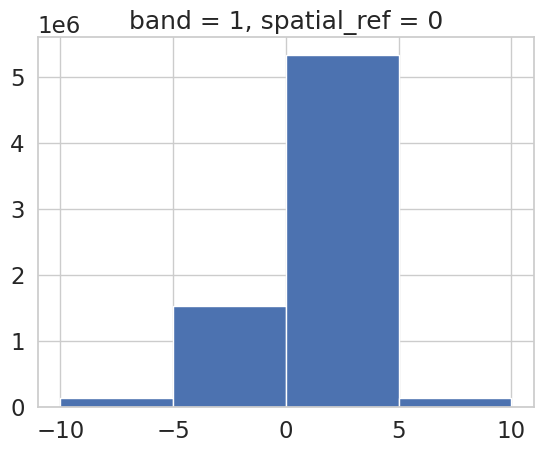

In [19]:
canopy_change.plot.hist(bins=[-10, -5, 0, 5, 10])

In [20]:
data_min_value = np.nanmin(canopy_change)
data_max_value = np.nanmax(canopy_change)
print(data_min_value, data_max_value)

-24.45996 23.429932


In [21]:
class_bins = [-np.inf, -5, 0, 0.01, 5, np.inf]

In [22]:
canopy_change_class = xr.apply_ufunc(np.digitize,
                                     canopy_change,
                                     class_bins)
canopy_change_class = canopy_change_class.where((canopy_change_class != 6) & (canopy_change_class != 3))

# NOTE Don't need this since when you do the class bins, there are only 4 classes
# canopy_change_class = canopy_change_class.where(canopy_change_class == 4, 3).where(canopy_change_class == 5, 4)

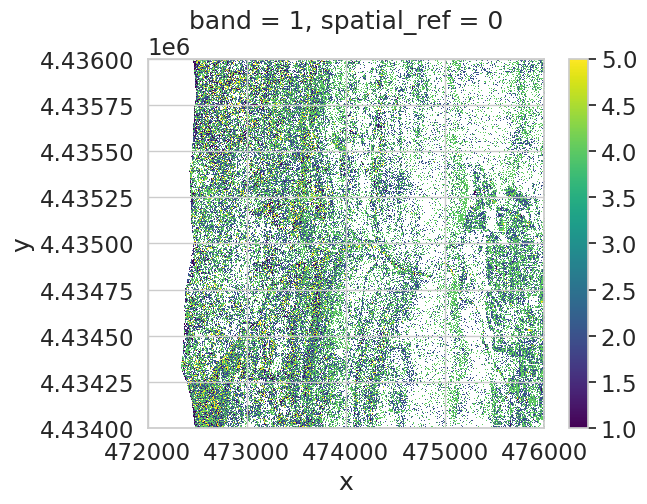

In [23]:
canopy_change_class.plot.imshow()

[Text(0.5, 1.0, 'Post Flood Change in Canopy Hight Model')]

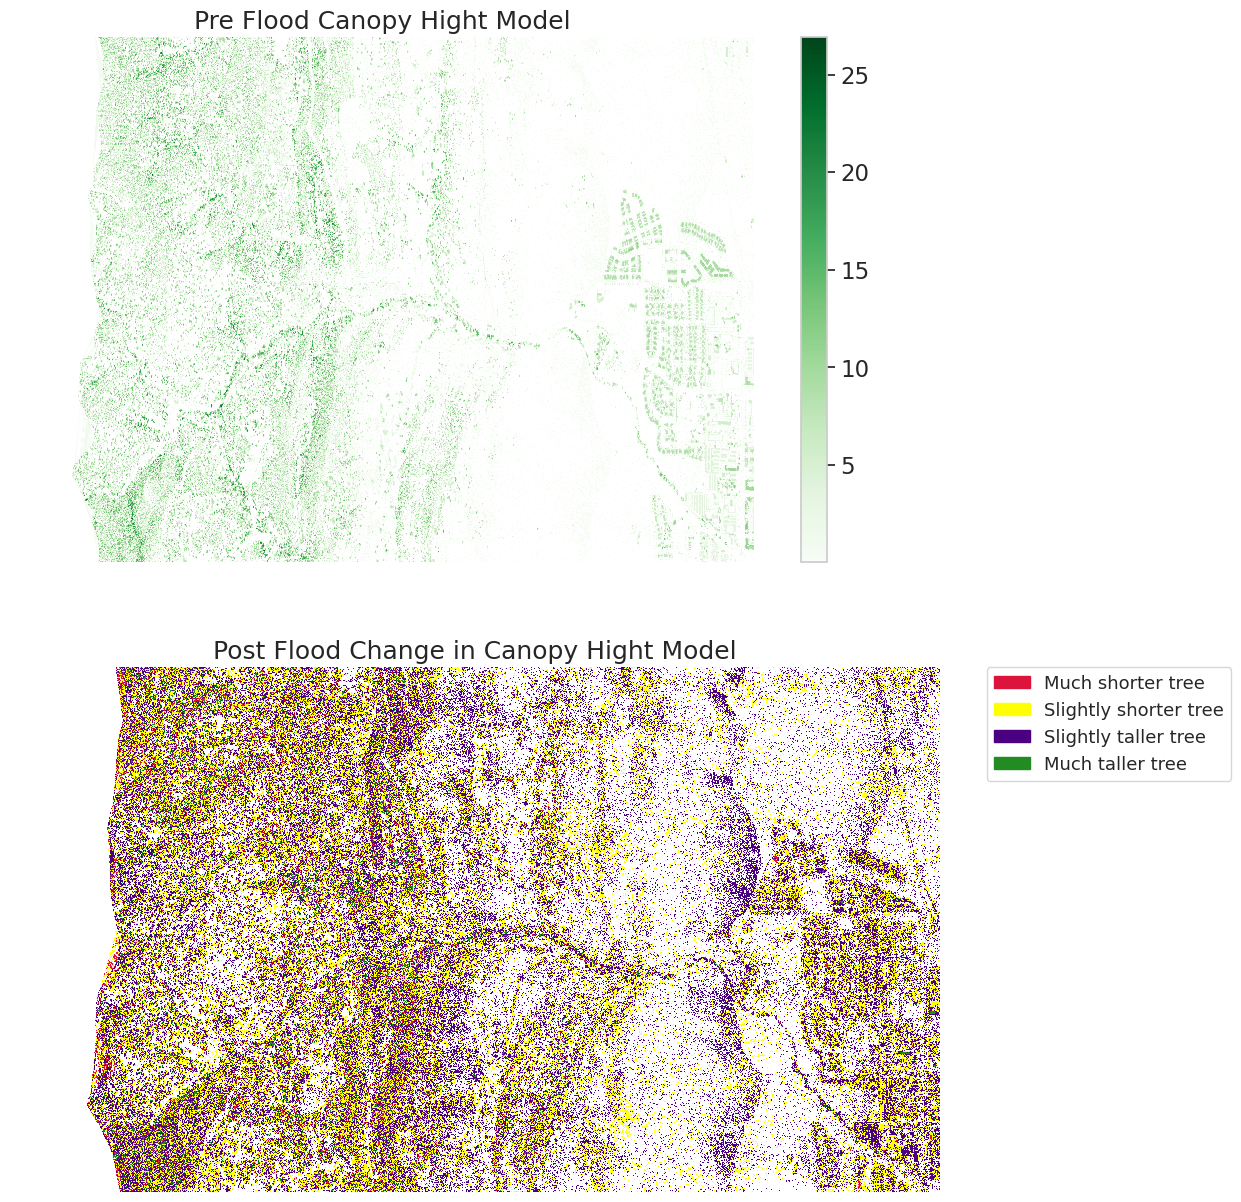

In [24]:
from matplotlib.colors import CenteredNorm
# Create a list of labels to use for your legend
height_class_labels = ["Much shorter tree",
                       "Slightly shorter tree",
                       "Slightly taller tree",
                       "Much taller tree"]

# Create a colormap from a list of colors
colors = ['crimson',
          'yellow',
          'indigo',
          'forestgreen']

cmap = ListedColormap(colors)

# 3 is being skipped since it represents no hange and has been filitered out
class_bins_plot = [0.1,1.1,2.1,4.1,5.1]
norm = BoundaryNorm(class_bins_plot,
                    len(colors))

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 15))

canopy_pre = canopy_pre.where(canopy_pre > 0)
# canopy_post = canopy_post.where(canopy_post > 0)

canopy_pre.plot.imshow(ax=ax[0], cmap="Greens")

change_ax = canopy_change_class.plot.imshow(ax=ax[1], cmap=cmap, norm=norm, add_colorbar=False)

ep.draw_legend(change_ax, titles=height_class_labels)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].set(title="Pre Flood Canopy Hight Model")
ax[1].set(title="Post Flood Change in Canopy Hight Model")

In [25]:
terrain_pre

<xarray.DataArray (band: 1, y: 2000, x: 4000)>
[8000000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

(array([4.080000e+02, 7.690000e+02, 9.710000e+02, 1.798000e+03,
        3.368000e+03, 6.147000e+03, 1.588830e+05, 6.983885e+06,
        1.371000e+03, 1.280000e+02]),
 array([-47.10009766, -40.42908859, -33.75807953, -27.08707237,
        -20.41606522, -13.74505615,  -7.07404804,  -0.40303954,
          6.26796865,  12.93897724,  19.60998535]),
 <BarContainer object of 10 artists>)

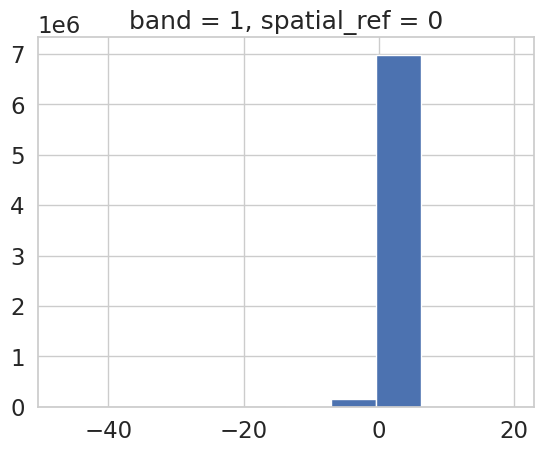

In [27]:
terrain_change.plot.hist()

In [31]:
print(np.nanmin(terrain_change.min()),
np.nanmax(terrain_change.max()))

-47.100098 19.609985


(array([6.729000e+03, 3.540900e+04, 6.918300e+04, 2.486460e+05,
        7.377460e+05, 2.565041e+06, 2.913330e+05, 2.181954e+06,
        6.159500e+05, 2.545480e+05, 8.411400e+04, 5.451500e+04,
        1.790000e+03]),
 array([-10.   ,  -5.   ,  -1.   ,  -0.5  ,  -0.25 ,  -0.125,   0.   ,
          0.01 ,   0.125,   0.25 ,   0.5  ,   1.   ,   5.   ,  10.   ]),
 <BarContainer object of 13 artists>)

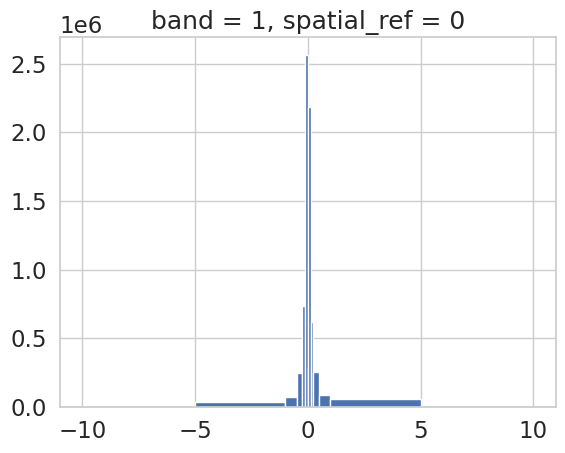

In [46]:
terrain_change.plot.hist(bins=[-10, -5, -1, -0.5, -0.25, -0.125, 0, 0.01, 0.125, 0.25, 0.5, 1, 5, 10])

In [47]:
class_bins_terrain = [-np.inf, -5, -1, -0.5, -0.25, -0.125, 0, 0.01, 0.125, 0.25, 0.5, 1, 5, np.inf]

In [48]:
terrain_change_class = xr.apply_ufunc(np.digitize,
                                      terrain_change,
                                      class_bins_terrain)
terrain_change_class = terrain_change_class.where((terrain_change_class != 7) & (terrain_change_class != 14))

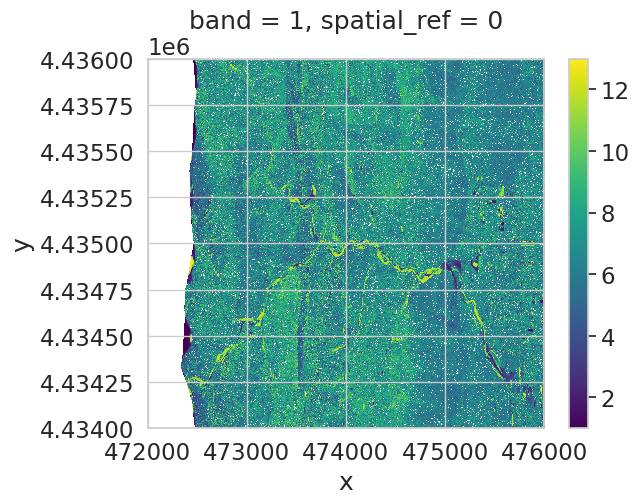

In [49]:
terrain_change_class.plot.imshow()

In [50]:
import matplotlib.colors as mcolors

[Text(0.5, 1.0, 'Post Flood Change in Digital Terrain Model')]

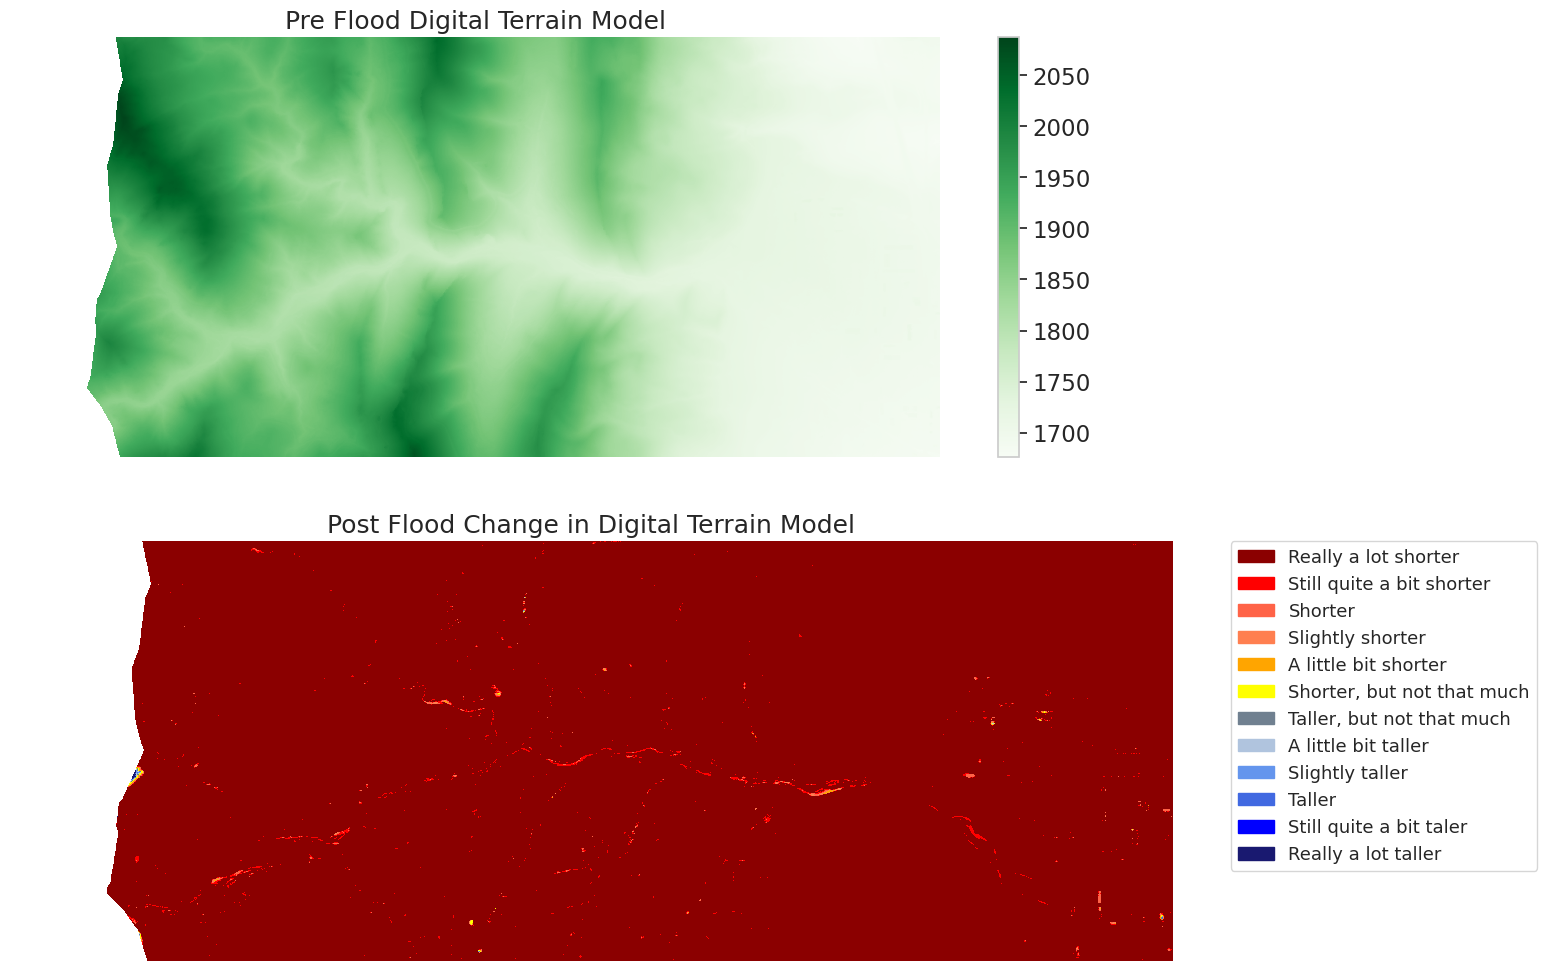

In [67]:
terrain_labels = ["Really a lot shorter",
                  "Still quite a bit shorter",
                  "Shorter",
                  "Slightly shorter",
                  "A little bit shorter",
                  "Shorter, but not that much",
                  "Taller, but not that much",
                  "A little bit taller",
                  "Slightly taller",
                  "Taller",
                  "Still quite a bit taler",
                  "Really a lot taller"
                  ]

terrain_colors = ["darkred", "red", "tomato", "coral", "orange", "yellow", "slategrey", "lightsteelblue", "cornflowerblue", "royalblue", "blue", "midnightblue"] # [name for name in mcolors.CSS4_COLORS]

terrain_classes_plot = [0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 7.1, 8.1, 9.1, 10.1, 11.1, 12.1]

cmap = ListedColormap(terrain_colors)

norm = BoundaryNorm(terrain_classes_plot, len(terrain_colors))

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

terrain_pre.squeeze().plot.imshow(cmap="Greens", ax=ax[0])

chng_plot = terrain_change.plot.imshow(cmap=cmap, norm=norm, add_colorbar=False, ax=ax[1])

ep.draw_legend(chng_plot, titles=terrain_labels, classes=terrain_classes_plot)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].set(title="Pre Flood Digital Terrain Model")
ax[1].set(title="Post Flood Change in Digital Terrain Model")

[Text(0.5, 1.0, 'Post Flood Change in Digital Terrain Model')]

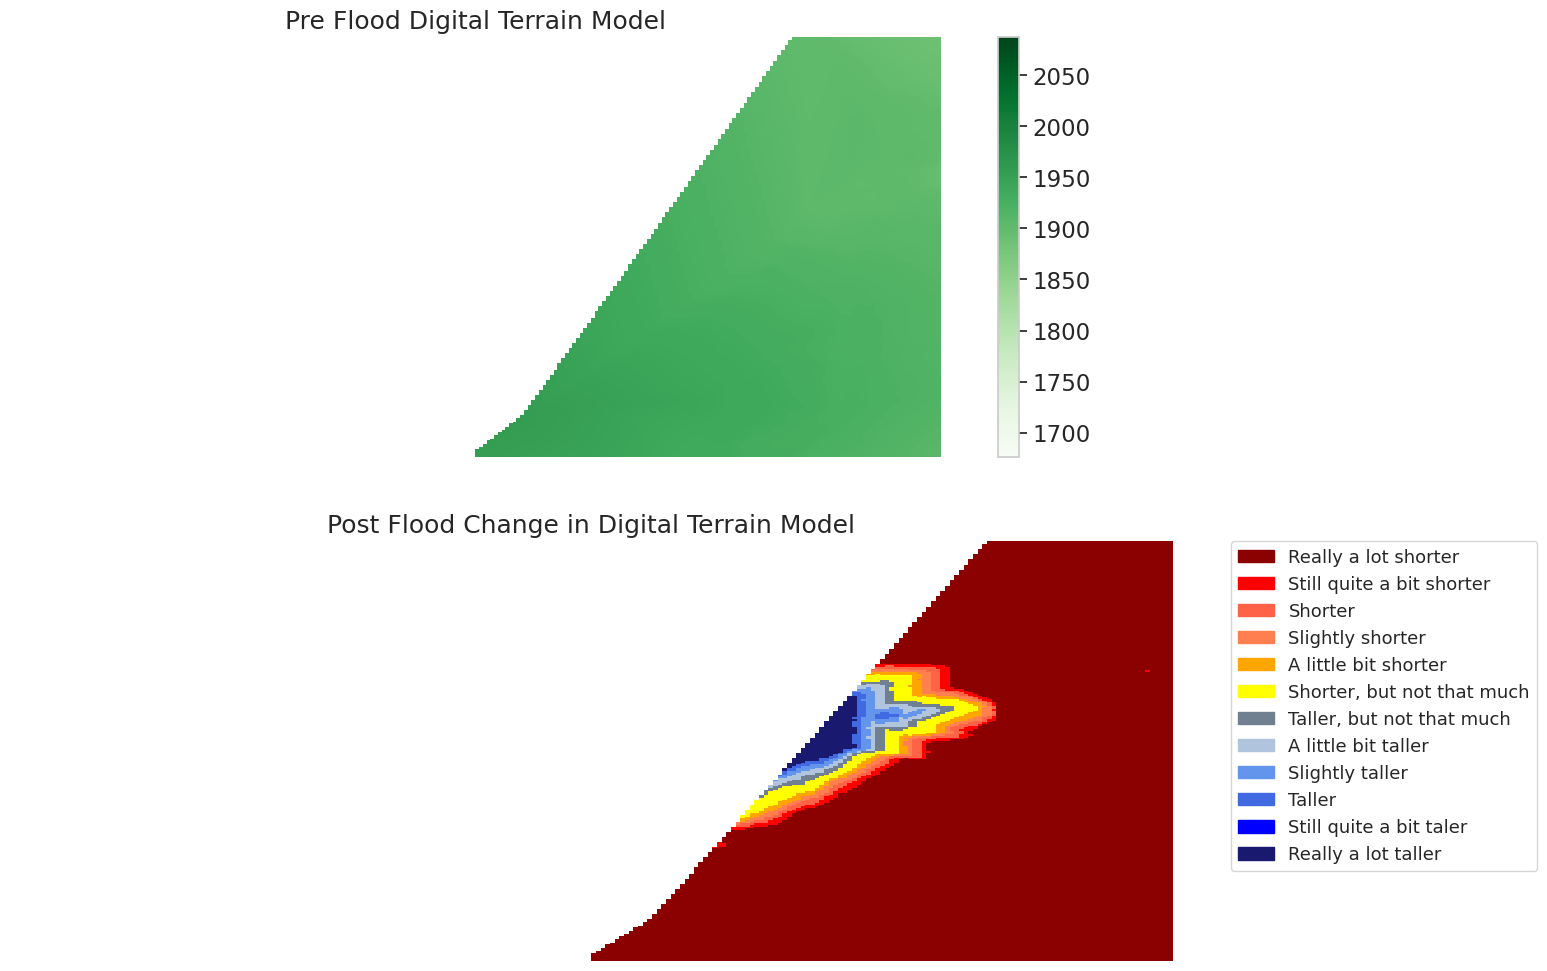

In [66]:
terrain_labels = ["Really a lot shorter",
                  "Still quite a bit shorter",
                  "Shorter",
                  "Slightly shorter",
                  "A little bit shorter",
                  "Shorter, but not that much",
                  "Taller, but not that much",
                  "A little bit taller",
                  "Slightly taller",
                  "Taller",
                  "Still quite a bit taler",
                  "Really a lot taller"
                  ]

terrain_colors = ["darkred", "red", "tomato", "coral", "orange", "yellow", "slategrey", "lightsteelblue", "cornflowerblue", "royalblue", "blue", "midnightblue"] # [name for name in mcolors.CSS4_COLORS]

terrain_classes_plot = [0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 7.1, 8.1, 9.1, 10.1, 11.1, 12.1]

cmap = ListedColormap(terrain_colors)

norm = BoundaryNorm(terrain_classes_plot, len(terrain_colors))

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

terrain_pre.squeeze().plot.imshow(cmap="Greens", ax=ax[0])

chng_plot = terrain_change.plot.imshow(cmap=cmap, norm=norm, add_colorbar=False, ax=ax[1])

ep.draw_legend(chng_plot, titles=terrain_labels, classes=terrain_classes_plot)

ax[0].set_ylim([4434750, 4435000])
ax[0].set_xlim([472250, 472500])
ax[1].set_ylim([4434750, 4435000])
ax[1].set_xlim([472250, 472500])
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].set(title="Pre Flood Digital Terrain Model")
ax[1].set(title="Post Flood Change in Digital Terrain Model")

In [ ]:
total_pixels = 2000 * 4000
positive_change = canopy_change.where(canopy_change > 0).count()
negative_change = canopy_change.where(canopy_change < 0).count()

I just realised, with raster data, the number of rows and columns is the number of pixels. Each row x column (i.e. each cell) represents a pixel in the pot, and the value of that cell is the intensity. When xarray.shape == (1, _, _), that means that the intensity value is just a number so all the plotting functions work pretty normally. But I suppose sometimes that value could be a tuple with RGB values like, (255, 132, 78).

In [ ]:
canopy_post.shape

(2000, 4000)

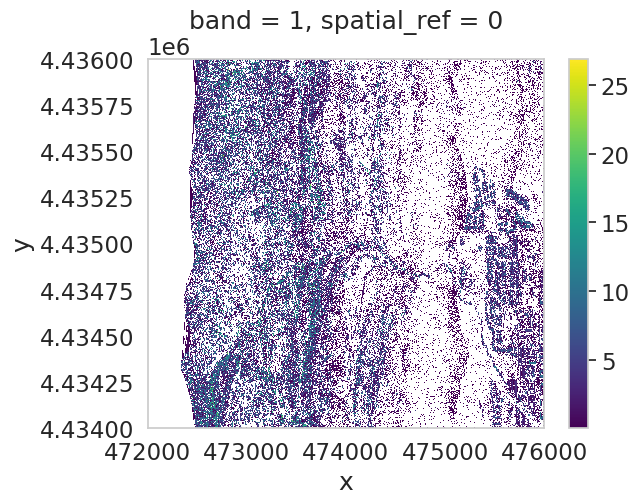

In [ ]:
canopy_pre.plot()